In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('rentprediction_dataset_v5.csv')
pd.set_option('display.max_columns', None)

print(df.columns.to_list())

['rent', 'age', 'sqmtr', 'newbuild', 'rooms', 'elabel', 'parking', 'bedrooms', 'bathrooms', 'floor', 'garden', 'balcony', 'rooftop', 'apartment', 'duplexmulti', 'luxury', 'singlefam', 'houseboat', 'pc4', 'percnative_pc4', 'sizehoudehold_pc4', 'percpropertyown_pc4', 'taxablepropertyvaluation', 'populationdensity_pc4', 'latitude', 'longitude', 'eucl_dist_to_Amstelland', 'eucl_dist_to_Amstelpark', 'eucl_dist_to_Amsterdamse Bos', 'eucl_dist_to_Beatrixpark', 'eucl_dist_to_Brasapark', 'eucl_dist_to_De Bretten', 'eucl_dist_to_Diemerpark', 'eucl_dist_to_Erasmuspark', 'eucl_dist_to_Flevopark', 'eucl_dist_to_Gaasperplas', 'eucl_dist_to_Gijsbrecht van Aemstelpark', 'eucl_dist_to_Houthavenpark', 'eucl_dist_to_Martin Luther Kingpark', 'eucl_dist_to_Nelson Mandelapark', 'eucl_dist_to_Noorder IJplas', 'eucl_dist_to_Noorderpark', 'eucl_dist_to_Oeverlanden', 'eucl_dist_to_Oosterpark', 'eucl_dist_to_Park Frankendael', 'eucl_dist_to_Park Schinkeleilanden', 'eucl_dist_to_Park Somerlust', 'eucl_dist_to_Rem

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

y = df['rent']
X = df.drop(columns={'rent'})

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.177, random_state=42)
# Evaluate performance for each transformation of rent

In [4]:
#checking optimal parameters for normal rent and transformed independent variables.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Define the transformation functions
def log_transform(x):
    return np.log(x + 1)  # Add 1 to avoid log(0)

def sqrt_transform(x):
    return np.sqrt(x)

def inverse_transform(x):
    return 1 / (x + 1)  # Avoid division by zero

def square_transform(x):
    return np.square(x)

def exp_transform(x):
    return np.exp(np.clip(x, None, 20))  # Clip to avoid very large values

# List of transformations
transformations = {
    'none': lambda x: x,
    'log': log_transform,
    'sqrt': sqrt_transform,
    'inverse': inverse_transform,
    'square': square_transform,
    'exp': exp_transform
}

# Function to determine if a variable is binary
def is_binary(series):
    return series.nunique() == 2

# Function to find the best transformation for each independent variable
def find_best_transformations(X, y):
    best_transformations = {}
    for column in X.columns:
        if is_binary(X[column]):
            best_transformations[column] = 'none'
            continue
        
        column_correlations = {}
        for name, func in transformations.items():
            try:
                transformed_column = func(X[column])
                if np.any(np.isnan(transformed_column)) or np.any(np.isinf(transformed_column)):
                    continue  # Skip transformation if it results in NaN or Inf values
                correlation = y.corr(transformed_column)
                column_correlations[name] = correlation
            except Exception as e:
                print(f"Transformation {name} failed for column {column} with error: {e}")
        
        if column_correlations:
            best_transformation = max(column_correlations, key=lambda k: abs(column_correlations[k]))
            best_transformations[column] = best_transformation
        else:
            best_transformations[column] = 'none'
    return best_transformations

# Function to transform DataFrame columns based on best transformations
def transform_dataframe(df, best_transformations):
    transformed_df = pd.DataFrame()
    for column in df.columns:
        best_transformation = best_transformations[column]
        if best_transformation == 'none':
            transformed_df[column] = df[column]
        else:
            transformed_df[f'{column}_{best_transformation}'] = transformations[best_transformation](df[column])
    
    transformed_columns = [f'{column}_{best_transformations[column]}' if best_transformations[column] != 'none' else column for column in df.columns]
    return transformed_df[transformed_columns]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True).astype(float)
y_train = np.log(y_train)

# Find the best transformations for X_train
best_transformations = find_best_transformations(X_train, y_train)

# Apply the best transformations to X_train and X_val
X_train_transformed = transform_dataframe(X_train, best_transformations)
X_val_transformed = transform_dataframe(X_val, best_transformations)
X_test_transformed = transform_dataframe(X_val, best_transformations)
y_train_transformed = y_train
y_val_transformed = np.log(y_val)
y_test_transformed = np.log(y_test)


# Print the best transformation for each column
print("Best transformations for each column:")
for column, transformation in best_transformations.items():
    print(f"{column}: {transformation}")

/home/anass/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anass/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anass/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anass/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_118215/1841743233.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_df[f'{column}_{best_transformation}'] = trans

Best transformations for each column:
age: log
sqmtr: sqrt
newbuild: none
rooms: none
elabel: log
parking: none
bedrooms: none
bathrooms: square
floor: log
garden: none
balcony: none
rooftop: none
apartment: none
duplexmulti: none
luxury: none
singlefam: none
houseboat: none
pc4: square
percnative_pc4: inverse
sizehoudehold_pc4: inverse
percpropertyown_pc4: sqrt
taxablepropertyvaluation: log
populationdensity_pc4: sqrt
latitude: square
longitude: inverse
eucl_dist_to_Amstelland: inverse
eucl_dist_to_Amstelpark: inverse
eucl_dist_to_Amsterdamse Bos: sqrt
eucl_dist_to_Beatrixpark: sqrt
eucl_dist_to_Brasapark: square
eucl_dist_to_De Bretten: sqrt
eucl_dist_to_Diemerpark: square
eucl_dist_to_Erasmuspark: square
eucl_dist_to_Flevopark: square
eucl_dist_to_Gaasperplas: square
eucl_dist_to_Gijsbrecht van Aemstelpark: sqrt
eucl_dist_to_Houthavenpark: inverse
eucl_dist_to_Martin Luther Kingpark: exp
eucl_dist_to_Nelson Mandelapark: square
eucl_dist_to_Noorder IJplas: sqrt
eucl_dist_to_Noorderpa

/tmp/ipykernel_118215/1841743233.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_df[f'{column}_{best_transformation}'] = transformations[best_transformation](df[column])
/tmp/ipykernel_118215/1841743233.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_df[f'{column}_{best_transformation}'] = transformations[best_transformation](df[column])
/tmp/ipykernel_118215/1841743233.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [5]:
print(best_transformations)

{'age': 'log', 'sqmtr': 'sqrt', 'newbuild': 'none', 'rooms': 'none', 'elabel': 'log', 'parking': 'none', 'bedrooms': 'none', 'bathrooms': 'square', 'floor': 'log', 'garden': 'none', 'balcony': 'none', 'rooftop': 'none', 'apartment': 'none', 'duplexmulti': 'none', 'luxury': 'none', 'singlefam': 'none', 'houseboat': 'none', 'pc4': 'square', 'percnative_pc4': 'inverse', 'sizehoudehold_pc4': 'inverse', 'percpropertyown_pc4': 'sqrt', 'taxablepropertyvaluation': 'log', 'populationdensity_pc4': 'sqrt', 'latitude': 'square', 'longitude': 'inverse', 'eucl_dist_to_Amstelland': 'inverse', 'eucl_dist_to_Amstelpark': 'inverse', 'eucl_dist_to_Amsterdamse Bos': 'sqrt', 'eucl_dist_to_Beatrixpark': 'sqrt', 'eucl_dist_to_Brasapark': 'square', 'eucl_dist_to_De Bretten': 'sqrt', 'eucl_dist_to_Diemerpark': 'square', 'eucl_dist_to_Erasmuspark': 'square', 'eucl_dist_to_Flevopark': 'square', 'eucl_dist_to_Gaasperplas': 'square', 'eucl_dist_to_Gijsbrecht van Aemstelpark': 'sqrt', 'eucl_dist_to_Houthavenpark': 

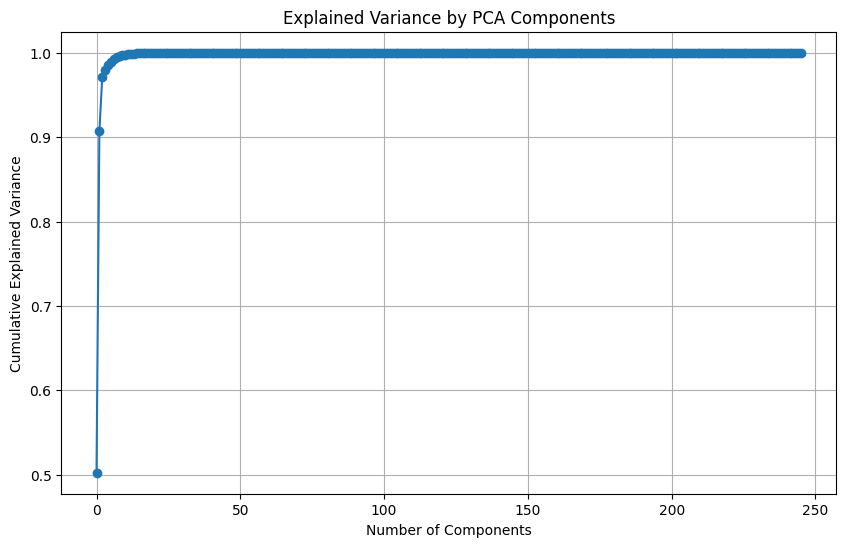

Number of components explaining 95.0% of variance: 3
     age  sqmtr  newbuild  rooms    elabel  parking  bedrooms  bathrooms  \
0   13.0   55.0       0.0    2.0  4.000000      0.0  1.000000   1.500000   
1  118.0  149.0       0.0    4.0  5.809297      0.0  3.000000   1.500000   
2    0.0   70.0       1.0    1.0  5.000000      0.0  1.455901   1.677056   
3    0.0   64.0       1.0    3.0  5.000000      0.0  2.000000   1.677867   
4    3.0   67.0       0.0    3.0  7.000000      0.0  2.000000   1.500000   

   floor  garden  balcony  rooftop  apartment  duplexmulti  luxury  singlefam  \
0    3.0     0.0      1.0      0.0        1.0          0.0     0.0        0.0   
1    3.0     0.0      1.0      0.0        1.0          0.0     0.0        0.0   
2   16.0     0.0      0.0      0.0        1.0          0.0     0.0        0.0   
3    9.0     0.0      0.0      0.0        1.0          0.0     0.0        0.0   
4    4.0     0.0      1.0      0.0        1.0          0.0     0.0        0.0   

   

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Standardize the location variables
location_columns = [col for col in X_train.columns if col.startswith('eucl_dist_to_')]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[location_columns])
X_val_scaled = scaler.transform(X_val[location_columns])
X_test_scaled = scaler.transform(X_test[location_columns])

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95  # for example, 95% variance
n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f"Number of components explaining {variance_threshold * 100}% of variance: {n_components}")

# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Combine PCA components with the original non-location features
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'pc_{i+1}' for i in range(n_components)])
X_val_pca_df = pd.DataFrame(X_val_pca, columns=[f'pc_{i+1}' for i in range(n_components)])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'pc_{i+1}' for i in range(n_components)])

# If you have other features, concatenate them with the PCA components
non_location_columns = [col for col in X_train.columns if not col.startswith('eucl_dist_to_')]
X_train_final = pd.concat([X_train[non_location_columns].reset_index(drop=True), X_train_pca_df], axis=1)
X_val_final = pd.concat([X_val[non_location_columns].reset_index(drop=True), X_val_pca_df], axis=1)
X_test_final = pd.concat([X_test[non_location_columns].reset_index(drop=True), X_test_pca_df], axis=1)

print(X_train_final.head())
print(X_val_final.head())
print(X_test_final.head())

# Fit the Linear Regression model with the reduced dataset
reg = LinearRegression().fit(X_train_final, y_train)

# Predict on the validation data
y_val_pred = reg.predict(X_val_final)

# Evaluate the model performance
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

print("\nPerformance Metrics on Validation Set:")
print(f"  MSE: {mse_val}")
print(f"  R2: {r2_val}")
print(f"  MAPE: {mape_val}")

# Predict on the training data
y_train_pred = reg.predict(X_train_final)

# Evaluate the model performance on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

print("\nPerformance Metrics on Training Set:")
print(f"  MSE: {mse_train}")
print(f"  R2: {r2_train}")
print(f"  MAPE: {mape_train}")


In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Standardize the location variables
location_columns = [col for col in X_train.columns if col.startswith('eucl_dist_to_')]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[location_columns])
X_val_scaled = scaler.transform(X_val[location_columns])
X_test_scaled = scaler.transform(X_test[location_columns])

# Apply PCA with 3 components
n_components = 3
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Combine PCA components with the original non-location features
non_location_columns = [col for col in X_train.columns if not col.startswith('eucl_dist_to_')]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'pc_{i+1}' for i in range(n_components)])
X_val_pca_df = pd.DataFrame(X_val_pca, columns=[f'pc_{i+1}' for i in range(n_components)])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'pc_{i+1}' for i in range(n_components)])

X_train_final = pd.concat([X_train[non_location_columns].reset_index(drop=True), X_train_pca_df], axis=1)
X_val_final = pd.concat([X_val[non_location_columns].reset_index(drop=True), X_val_pca_df], axis=1)
X_test_final = pd.concat([X_test[non_location_columns].reset_index(drop=True), X_test_pca_df], axis=1)

print(X_train_final.head())
print(X_val_final.head())
print(X_test_final.head())

# Fit the Linear Regression model with the reduced dataset
reg = LinearRegression().fit(X_train_final, y_train)

# Predict on the validation data
y_val_pred = reg.predict(X_val_final)

# Evaluate the model performance
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

print("\nPerformance Metrics on Validation Set:")
print(f"  MSE: {mse_val}")
print(f"  R2: {r2_val}")
print(f"  MAPE: {mape_val}")

# Predict on the training data
y_train_pred = reg.predict(X_train_final)

# Evaluate the model performance on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

print("\nPerformance Metrics on Training Set:")
print(f"  MSE: {mse_train}")
print(f"  R2: {r2_train}")
print(f"  MAPE: {mape_train}")


     age  sqmtr  newbuild  rooms    elabel  parking  bedrooms  bathrooms  \
0   13.0   55.0       0.0    2.0  4.000000      0.0  1.000000   1.500000   
1  118.0  149.0       0.0    4.0  5.809297      0.0  3.000000   1.500000   
2    0.0   70.0       1.0    1.0  5.000000      0.0  1.455901   1.677056   
3    0.0   64.0       1.0    3.0  5.000000      0.0  2.000000   1.677867   
4    3.0   67.0       0.0    3.0  7.000000      0.0  2.000000   1.500000   

   floor  garden  balcony  rooftop  apartment  duplexmulti  luxury  singlefam  \
0    3.0     0.0      1.0      0.0        1.0          0.0     0.0        0.0   
1    3.0     0.0      1.0      0.0        1.0          0.0     0.0        0.0   
2   16.0     0.0      0.0      0.0        1.0          0.0     0.0        0.0   
3    9.0     0.0      0.0      0.0        1.0          0.0     0.0        0.0   
4    4.0     0.0      1.0      0.0        1.0          0.0     0.0        0.0   

   houseboat     pc4  percnative_pc4  sizehoudehold_pc4 